## Hypothesis I - Proposed Modeling Approach I

##### Input: PCA Dimensions

##### Downstream Model: XGBoost

##### Validation: 5-fold CV


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

import shap

import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Preprocessing


In [2]:
LATE_BOOT_DATES = ["2021-06-14", "2021-06-23", "2021-06-30", "2021-07-28"]

# load 2021 (training)
df_2021 = pd.read_csv("../../../../Datasets/2021/Dataset_2021.csv")
df_2021 = df_2021.sort_values(by=["Date", "Plot_Number"])

# remove missing yield
df_2021 = df_2021[df_2021["Yield"].notna()]

# Only keep dates that occur on/before late booting stage
df_2021["Date"] = pd.to_datetime(df_2021["Date"]).dt.strftime("%Y-%m-%d")
df_2021 = df_2021[df_2021["Date"].isin(LATE_BOOT_DATES)]

# remove vegetation fraction
df_2021.drop("Vegetation_Fraction", axis=1, inplace=True)

**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [4]:
seedCounter = 100
trainPlots = []
testPlots = []
tmp = df_2021[df_2021["Date"] == df_2021["Date"].unique()[0]]

for e in tmp["Experiment_Name"].unique():
    for c in tmp[tmp["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in tmp[(tmp["Experiment_Name"] == e) & (tmp["Rice_Cultivar"] == c)][
            "Nitrogen_Rate"
        ].unique():
            replicates = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
                & (tmp["Replicate"] != picked)
            ]["Plot_Number"].values

            test = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
                & (tmp["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter

Experiment: Tiara, Cultivar: IAC600, Nitrogen: 75 
Train plots: [33769 33771 33779 33783]
Test plots: [33761 33766]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 150 
Train plots: [33786 33788 33801 33807]
Test plots: [33795 33798]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 200 
Train plots: [33821 33822 33826 33832]
Test plots: [33810 33816]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 75 
Train plots: [33762 33765 33777 33781]
Test plots: [33773 33775]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 150 
Train plots: [33785 33792 33803 33804]
Test plots: [33794 33799]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 200 
Train plots: [33820 33824 33830 33831]
Test plot

In [5]:
dfTrain = df_2021[df_2021["Plot_Number"].isin(trainPlots)]

# scale features
scaler = StandardScaler()
dfTrain.iloc[:, 17:] = scaler.fit_transform(dfTrain.iloc[:, 17:])

dfUavTrain = dfTrain.iloc[:, 17:]
dfLabelsTrain = dfTrain.iloc[:, :17]

### Load PCA Embedding


In [6]:
embedding = joblib.load("Saved_Models/PCA_EMBEDDING")
dfEmbeddingTrain = pd.concat(
    [
        dfLabelsTrain.reset_index(drop=True),
        pd.DataFrame(embedding.transform(dfUavTrain)),
    ],
    axis=1,
)

### Preprocess PCA dimensions


In [7]:
# rename components
for i in range(len(dfLabelsTrain.columns), len(dfEmbeddingTrain.columns), 1):
    dfEmbeddingTrain.rename(
        columns={
            dfEmbeddingTrain.columns[i]: "PCA_"
            + str(i - len(dfLabelsTrain.columns) + 1)
        },
        inplace=True,
    )

# retain only first 10 PCs
dfEmbeddingTrain = dfEmbeddingTrain.loc[:, "Date":"PCA_10"]

# wide to long then long to wide
dfLongTrain = pd.melt(
    dfEmbeddingTrain.iloc[:, np.r_[0:8, 17 : len(dfEmbeddingTrain.columns)]],
    id_vars=dfEmbeddingTrain.iloc[:, 0:8],
    value_vars=dfEmbeddingTrain.iloc[:, 17:],
)

dfWideTrain = pd.pivot(
    dfLongTrain,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTrain.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTrain.columns.tolist()
]

del dfLongTrain

### Training


In [8]:
def xgbCV(xTrain, yTrain, params, nfolds, rounds):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=100)

    cvResults = []
    for trainIndices, valIndices in kfold.split(xTrain):
        xTrainCV, xValCV = xTrain[trainIndices], xTrain[valIndices]
        yTrainCV, yValCV = yTrain[trainIndices], yTrain[valIndices]

        # convert into DMatrix format for training
        dtrainCV = xgb.DMatrix(xTrainCV, label=yTrainCV)
        dvalCV = xgb.DMatrix(xValCV, label=yValCV)

        evalsResult = {}

        # train model
        model = xgb.train(
            params=params,
            dtrain=dtrainCV,
            num_boost_round=rounds,
            maximize=False,
            evals=[(dtrainCV, "train"), (dvalCV, "validation")],
            evals_result=evalsResult,
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        cvResults.append(evalsResult)

    return cvResults


def getAttributes(cvResults):
    """
    Returns the minimum CV score (RMSE) and its corresponding best iteration across all folds
    """

    # get fold with the least iterations
    minList = -1
    for x1 in cvResults:
        valList = len(x1["validation"]["rmse"])
        if minList == -1 or valList < minList:
            minList = valList

    bestIteration = -1
    minAverage = -1
    for i in range(0, minList, 1):
        rmseScores = []

        # get rmse score of each fold in iteration i
        for k in cvResults:
            rmseScores.append(k["validation"]["rmse"][i])

        # average all scores
        avg = np.mean(rmseScores)
        if minAverage == -1 or avg < minAverage:
            minAverage = avg
            bestIteration = i + 1

    return [minAverage, bestIteration]

In [9]:
xTrain = dfWideTrain.iloc[:, 7:].values
yTrain = dfWideTrain["Yield"]
N_FOLDS = 5
MAX_ROUNDS = 5000

# create DMatrix
dtrain = xgb.DMatrix(xTrain, label=yTrain)

# Set default params
xgbDefaultParams = {
    "booster": "gbtree",
    "objective": "reg:squarederror",
    "eta": 0.3,
    "gamma": 0,
    "max_depth": 6,
    "min_child_weight": 1,
    "subsample": 1,
    "colsample_bytree": 1,
    "lambda": 1,
    "alpha": 0,
}

cvResults = getAttributes(xgbCV(xTrain, yTrain, xgbDefaultParams, N_FOLDS, MAX_ROUNDS))

# Train model with default params
xgbDefault = xgb.train(
    params=xgbDefaultParams,
    dtrain=dtrain,
    num_boost_round=cvResults[1],
    maximize=False,
)

print(f"RMSE 5-fold CV: {cvResults[0]}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, xgbDefault.predict(dtrain), squared=False)}"
)

RMSE 5-fold CV: 1.9851471974370896
Training RMSE: 0.03613129234909148


### Tuning Model Hyperparameters


In [10]:
def blackBoxXgb(
    eta, gamma, max_depth, min_child_weight, subsample, colsample_bytree, lambdaa, alpha
):
    paramList = {
        "objective": "reg:squarederror",
        "eta": eta,
        "gamma": gamma,
        "max_depth": round(max_depth),
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "lambda": lambdaa,
        "alpha": alpha,
    }

    xgbCVTest = xgb.cv(
        params=paramList,
        dtrain=dtrain,
        num_boost_round=MAX_ROUNDS,
        nfold=N_FOLDS,
        metrics="rmse",
        maximize=False,
        early_stopping_rounds=10,
        seed=100,
    )
    bayesianScores.append(
        {
            "eta": eta,
            "gamma": gamma,
            "max_depth": round(max_depth),
            "min_child_weight": min_child_weight,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "lambda": lambdaa,
            "alpha": alpha,
            "num_boost_round": xgbCVTest.shape[0],
            "score": -1.0 * xgbCVTest["test-rmse-mean"].iloc[-1],
        }
    )

    return -1.0 * xgbCVTest["test-rmse-mean"].iloc[-1]

In [11]:
# define lower and upper bounds of parameter space
paramBounds = {
    "eta": (0.01, 1),
    "gamma": (0, 5),
    "max_depth": (3, 10),
    "min_child_weight": (1, 10),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "lambdaa": (0, 5),
    "alpha": (0, 5),
}

bayesianScores = []

bayOptimizer = BayesianOptimization(
    f=blackBoxXgb,
    pbounds=paramBounds,
    random_state=100,
    verbose=2,
    bounds_transformer=SequentialDomainReductionTransformer(),
)
bayOptimizer.maximize(init_points=24, n_iter=20)

# get parameters of best score
bayBestParams = max(bayesianScores, key=lambda x: x["score"])
xgbNewParams = {
    "objective": "reg:squarederror",
    "eta": bayBestParams["eta"],
    "gamma": bayBestParams["gamma"],
    "max_depth": bayBestParams["max_depth"],
    "min_child_weight": bayBestParams["min_child_weight"],
    "subsample": bayBestParams["subsample"],
    "colsample_bytree": bayBestParams["colsample_bytree"],
    "lambda": bayBestParams["lambda"],
    "alpha": bayBestParams["alpha"],
}

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambdaa  | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -2.103    | 2.717     | 0.3505    | 0.4303    | 4.224     | 0.02359   | 3.851     | 7.037     | 0.8433    |
| 2         | -2.22     | 0.6835    | 0.6176    | 0.8924    | 1.046     | 0.9266    | 3.759     | 2.977     | 0.9808    |
| 3         | -2.529    | 4.058     | 0.2547    | 0.8181    | 1.37      | 2.159     | 9.58      | 8.359     | 0.4025    |
| 4         | -1.823    | 0.8771    | 0.4355    | 0.01563   | 1.262     | 3.978     | 3.107     | 6.39      | 0.6434    |
| 5         | -1.878    | 0.5257    | 0.4437    | 0.04611   | 4.452     | 4.905     | 3.42      | 9.015     | 0.6192    |
| 6         | -2.672    | 3.712     | 0.6672    | 0.586     | 0.1022    | 1.05      | 6.813     | 7.922     | 0.3256    |
| 7         | -3.082    

### Visualize Training and Validation Errors


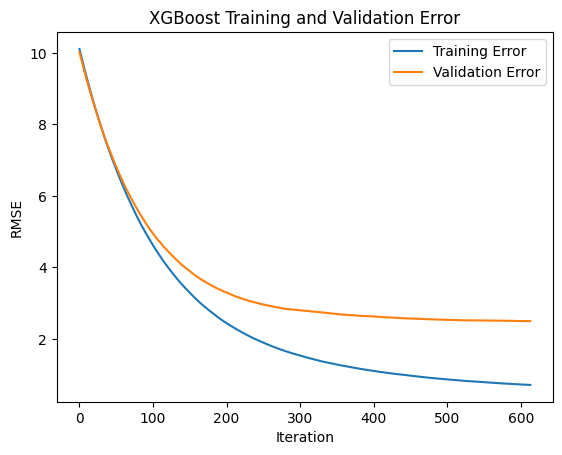

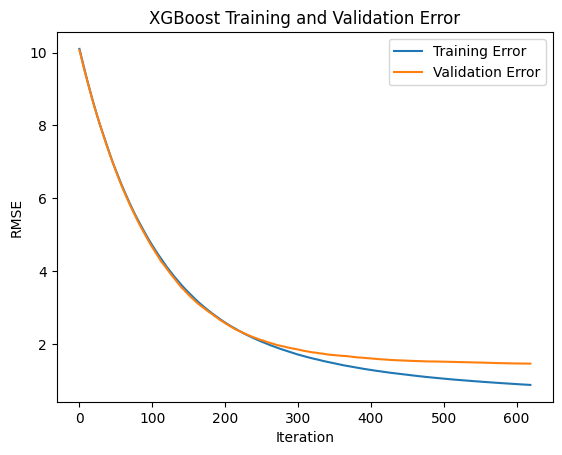

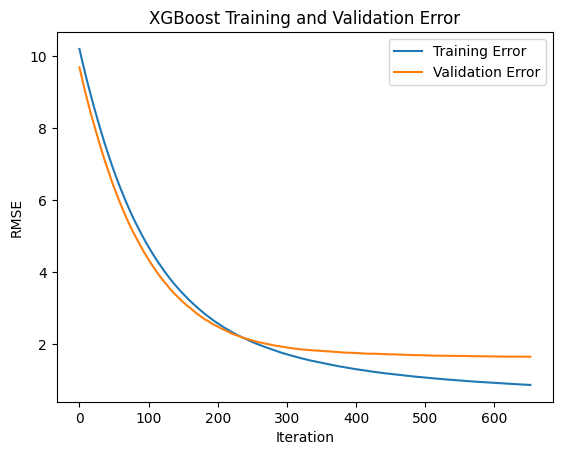

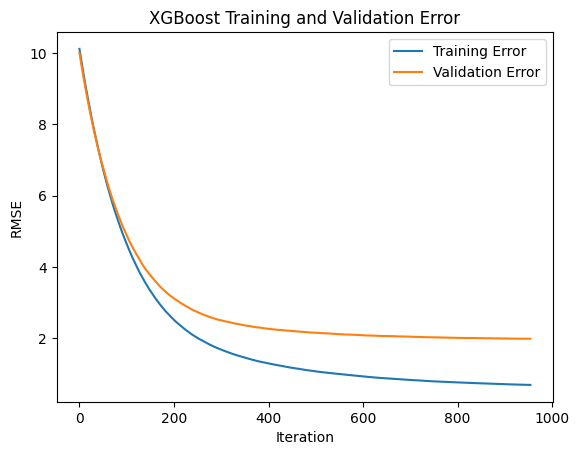

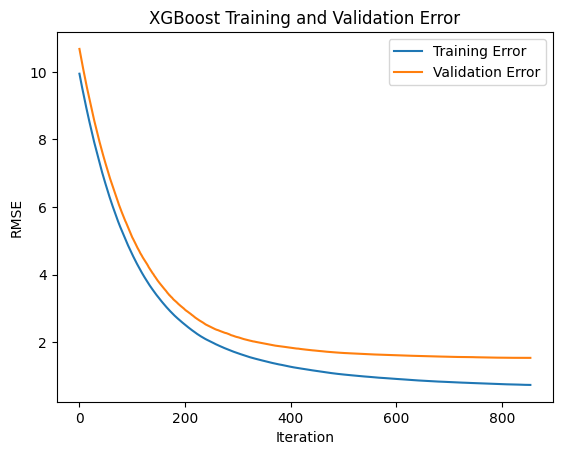

In [12]:
foldScores = xgbCV(xTrain, yTrain, xgbNewParams, N_FOLDS, MAX_ROUNDS)
cvResults = getAttributes(foldScores)

# Visualize training and validation error for each fold
for fold in foldScores:
    training_rounds = range(len(fold["train"]["rmse"]))
    plt.figure()
    plt.plot(training_rounds, fold["train"]["rmse"], label="Training Error")
    plt.plot(training_rounds, fold["validation"]["rmse"], label="Validation Error")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.title("XGBoost Training and Validation Error")
    plt.show()

In [13]:
# Train model with optimized params
xgbTuned = xgb.train(
    params=xgbNewParams,
    dtrain=dtrain,
    num_boost_round=300,
    maximize=False,
)

print(f"RMSE 5-fold CV: {cvResults[0]}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, xgbTuned.predict(dtrain), squared=False)}"
)

RMSE 5-fold CV: 1.860656354062052
Training RMSE: 1.6335339700732137


### Interpret Model


In [14]:
explainer = shap.Explainer(xgbTuned)
shapValues = explainer(xTrain)

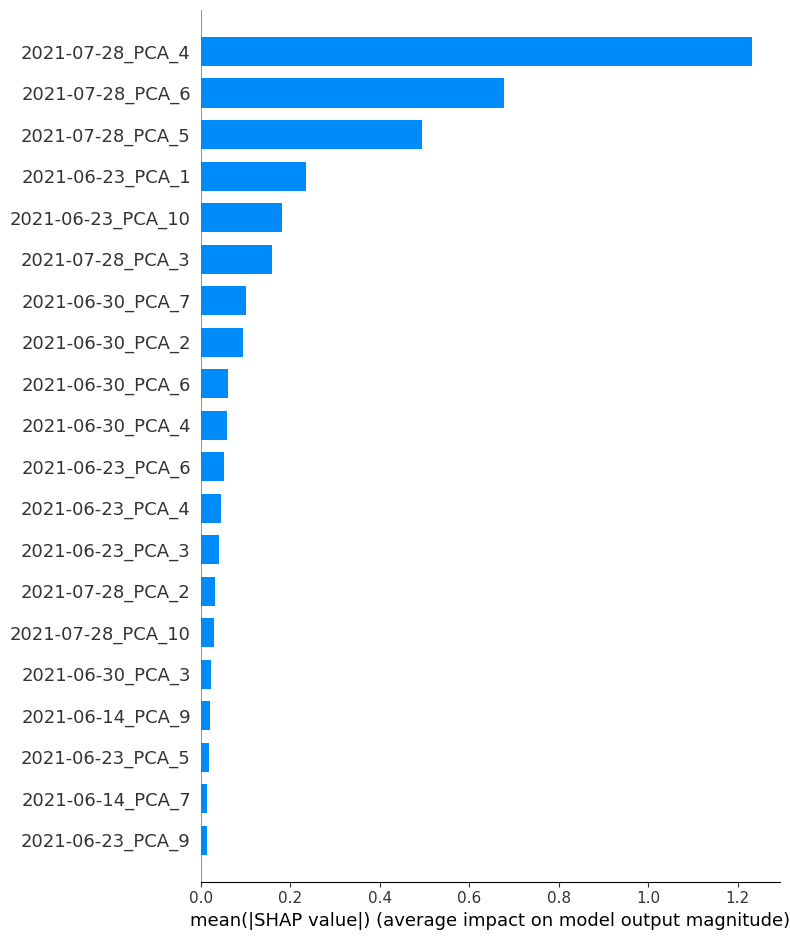

In [15]:
shap.summary_plot(shapValues, plot_type="bar", feature_names=dfWideTrain.columns[7:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


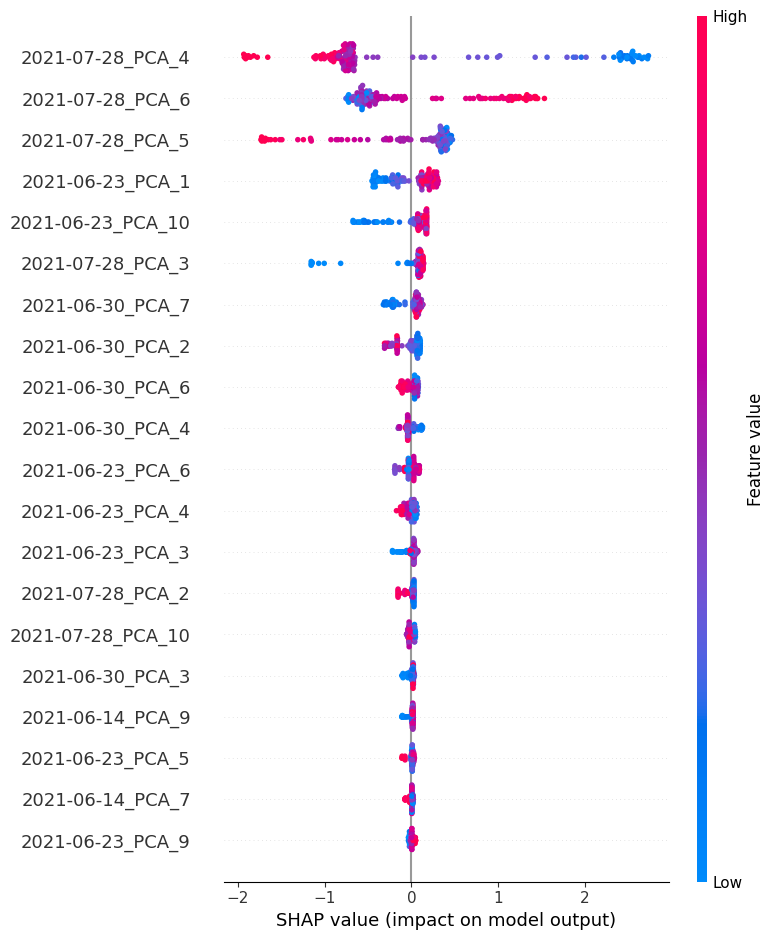

In [16]:
shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTrain.columns[7:])

### Export Models


In [ ]:
# save tuned model
joblib.dump(xgbTuned, "Saved_Models/H1A1M2")